# Semantic segmentation with Deep Learning
Centrale Nantes

Supervisor: Diana Mateus

Participants: WANG Ning

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Introduction

For quantitative analysis, cells in microscopic images need to be segmented from the image. In this notebook we will model the problem in terms of semantic segmentation and approach it by means of deep learning, and more specifically with the U-Net architecture.

### 1. Load modules and data

#### 1.1 Import modules

In [6]:
#4S
# Import all the necessary libraries
import os
import datetime 
import glob                                           #filename pattern matching
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#SKIMAGE
import skimage.io                                     #Used for imshow function
import skimage.transform                              #Used for resize function
import skimage.exposure                               #Used for displaying 

#Tensorflow, Keras and related modules
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.layers import add, concatenate
#from keras.layers import LeakyReLU


#To save and reload models
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.utils import  plot_model
#from tensorflow.keras.utils import multi_gpu_model

#For data augmentation
#from keras.preprocessing.image import ImageDataGenerator    
#from keras.callbacks import EarlyStopping, ModelCheckpoint

#Sklearn 
import sklearn
from sklearn.model_selection import train_test_split

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Skimage      :', skimage.__version__)
print('Scikit-learn :', sklearn.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.6.9 (default, Oct  8 2020, 12:12:24) 
Numpy        : 1.19.5
Skimage      : 0.16.2
Scikit-learn : 0.22.2.post1
Tensorflow   : 2.4.0


#### 1.2 Define global parameters
- Set seed for random values to a fix number (42) to ensure that we get images and masks that correspond to each other. 
- Define the image size here
``` img_height, img_width ```. Default is = (256,256)
- You may want to reduce size for training i

In [7]:
#4S
# Set seed values
seed = 42
random.seed = seed
np.random.seed(seed=seed)

# Set number of GPUs
#num_gpus = 1   #defaults to 1 if one-GPU or one-CPU. If 4 GPUs, set to 4.

# Set height (y-axis length) and width (x-axis length) to train model on
img_height, img_width = (64,64)  #Default to (256,266), use (None,None) if you do not want to resize imgs

#### 1.3.1 Define the data path
Define the data path and change the directory to the defined topDir. Also specify the train and test directories

In [8]:
#4S
#topDir = "../DATA/" 
topDir = "/content/drive/MyDrive"
inormin = 'input'
os.chdir(topDir)    
print(os.listdir(os.path.join(topDir, 'mini-input')))  #see what's in the input folder (where data is in)
train_path = os.path.join(topDir, 'mini-input/stage1_train')  #path to training data file/folder
test_path = os.path.join(topDir, 'mini-input/stage1_test')   #path to test data file/folder

['stage1_test', 'stage1_train']


#### 1.3.2 Read and preload the input image data
Read the data and create a tensor containing all the train and test data as well as their corresponding labels.

The following function ``get_images``  
- receives as input an image path (can be train or test), and a desired image shape for the output
- lists all files in the input image path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread``
- uses ``skimage.transform.resize`` to directly downsample the images according to the ``img_height, img_width`` parameters.
- uses only the first three channels of the images.
- returns a numpy array (matrix) . Hint: define an ``np.array`` of type ``dtype=np.uint8`` to stock the data.
- uses ``%%time`` to display the time spent in loading.
- Runs the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3) uint8 

In [9]:
%%time
# Get training data
def get_images(path, output_shape=(None, None)):
    '''
    Loads images from path/{id}/images/{id}.png into a numpy array
    '''
    img_paths = ['{0}/{1}/images/{1}.png'.format(path, id) for id in os.listdir(path) if id != ".DS_Store"]

    #X_data = np.array([skimage.io.imread(path)[:,:,:3] for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands

    X_data = np.array([skimage.transform.resize(skimage.io.imread(path)[:,:,:3], output_shape=output_shape, mode='constant', preserve_range=True) for path in img_paths], dtype=np.uint8)  #take only 3 channels/bands
    
    return X_data
X_train = get_images(train_path, output_shape=(img_height,img_width))
print(X_train.shape, X_train.dtype)
    


(50, 64, 64, 3) uint8
CPU times: user 2.54 s, sys: 5.17 s, total: 7.7 s
Wall time: 25.8 s


#### 1.3.3 Read and preload the anotations
The following function ``get_labels``  
- receives as input a mask path (can be train or test), and a desired image shape for the output.
- lists all files in the input path. Hint: use ``os.listdir``.
- reads each of the files with ``skimage.io.imread``
- uses ``skimage.transform.resize`` to directly downsample the masks according to the ``img_height, img_width`` parameters.
- returns a numpy array (matrix) . Hint: define an ``np.array`` of type ``dtype=np.uint8`` to stock the data.
- uses ``%%time`` to display the time spent in loading.
- Runs the function and print the shape and type of the resulting array (e.g. (670, 256, 256, 3)) uint8 
- This can take some minutes (reduce the number of images to accelerate the first tests and reduce memory demands if necessary)

In [10]:
%%time
# Get training data labels
def get_labels(path, output_shape=(None, None)):
    '''
    Loads and concatenates images from path/{id}/masks/{id}.png into a numpy array
    '''
    img_paths = [glob.glob('{0}/{1}/masks/*.png'.format(path, id)) for id in os.listdir(path) if id != ".DS_Store"]
    
    Y_data = []
    for i, img_masks in enumerate(img_paths):  #loop through each individual nuclei for an image and combine them together
        masks = skimage.io.imread_collection(img_masks).concatenate()  #masks.shape = (num_masks, img_height, img_width)
        mask = np.max(masks, axis=0)                                   #mask.shape = (img_height, img_width)
        mask = skimage.transform.resize(mask, output_shape=output_shape+(1,), mode='constant', preserve_range=True)  #need to add an extra dimension so mask.shape = (img_height, img_width, 1)
        Y_data.append(mask)

    # make sure to return the binary images but coded as floats to be compatible with the loss functions
    Y_data = np.array(Y_data, dtype=np.bool)
    
    return Y_data    
    
Y_train = get_labels(train_path, output_shape=(img_height,img_width))

print("We have {} labeled images of size ({},{}) and type {}".format(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],Y_train.dtype))




We have 50 labeled images of size (64,64) and type bool
CPU times: user 6.75 s, sys: 6.66 s, total: 13.4 s
Wall time: 8min 40s


In [12]:
Y_train =1.0*Y_train.astype(float)

#### 1.4 Visualize some examples of images and matching labels
Choose one index among the lists of images and labels and use ``plt.imshow`` to visualize side by side the corresponding image and mask.
You may want to use ```skimage.exposure.rescale_intensity``` for better visualization of the input.

Looking at image  38
(50, 64, 64, 1)


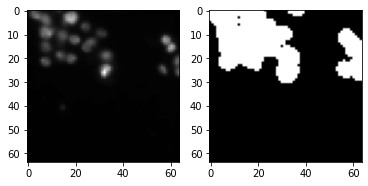

In [13]:
%matplotlib inline

idx = np.random.randint(Y_train.shape[0], size=1)[0]

print ('Looking at image ', idx)

fig, axis = plt.subplots(nrows = 1, ncols = 2)

print(Y_train.shape)

axis[0].imshow(skimage.exposure.rescale_intensity(X_train[idx, :, :, :]))
axis[1].imshow(np.reshape(Y_train[idx, :, :, :], (Y_train.shape[1], Y_train.shape[2])),cmap='gray') #why 3 spaces if ytrain is of different shape, why resize needed?
#axis[1].imshow(Y_train[idx, :, :],cmap='gray')

### 2. Buidling the U-Net model
#### 2.1. Define the architecture

**a)** Building the model
- Create a function ```model``` that receives as input the image size 
- Start by predefining as parameters within the function
    - the number of kernels/feature channels per block. Usually they have increasing powers of 2. For instance, ```n_channels=[16,32,64,128,256]```
    - a global kernel size ```(3,3)```
    - a weight initialization method (try `he_normal`)
- Create an input layer using the Keras function ``Input``
- Declare the encoder blocks each composed of:
    - two convolutional layers (with the same number of input channels). Use ``Conv2D``.
    - one maxpool layer (except for the last block). Use ``MaxPooling2D``
    - use relu activations
    - create a list pointing to each encoder blocks to be able to refer to them later while creating the skip connections
    - **Hint** Define one block of convolution+pool+relu then create a loop to iterate over the different blocks

- Define the decoder blocks each composed of:
    - one Transpose convolution layer.
    - two convolutional layers. 
    - use relu activations
    - create a list with pointers to each decoder blocks to be able to refer to them later the skip connections
    - **Hint** Define one block of transposed convolution+conv+relu then create a loop to iterate over the different blocks


- The output layer should be a Transpose convolution layer with a 'sigmoid' activatin and a 'glorot_normal' initialization

- Use the lists created above to create the skip connections 
    - connecting for each resolution the output of the encoder blocks to the input of the decoder blocks.

- Use the keras function ``Model`` to identify this function as the architecture and use the output of ```Model``` as the return value of the unet_model function


In [100]:
# Design our model architecture here
def unet_model(img_width=256, img_height=256):
    
    #define the architecture parameters
    n_channels = [16,32,64,128,256]  #the number of kernels/feature channels per block
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer
    l_conv1 = [] #list of the first convolutional layers of each encoder block
    l_conv2 = [] #list of the second convolutional layers of each encoder block
    output_enc = [] #list of econder blocks, append here the blocks you want to connect with skip connections
    l_maxpool = [] #list of the maxpool outputs
    l_tconv = [] # list of the ouputs of the transposed convolution
    
    # Use Keras Input layer to create one
    inp = Input(shape=[img_width,img_height,3])
    

    # Encoder
    conv1 = Conv2D(n_channels[0],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(inp)
    conv2 = Conv2D(n_channels[0],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2,2),padding='same')(conv2)

    conv3 = Conv2D(n_channels[1],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(pool1)
    conv4 = Conv2D(n_channels[1],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(conv3)
    pool2 = MaxPooling2D(pool_size=(2,2),padding='same')(conv4)

    conv5 = Conv2D(n_channels[2],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(pool2)
    conv6 = Conv2D(n_channels[2],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(conv5)
    pool3 = MaxPooling2D(pool_size=(2,2),padding='same')(conv6)

    conv7 = Conv2D(n_channels[3],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(pool3)
    conv8 = Conv2D(n_channels[3],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(conv7)
    pool4 = MaxPooling2D(pool_size=(2,2),padding='same')(conv8)

    conv9 = Conv2D(n_channels[4],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(pool4)
    conv10 = Conv2D(n_channels[4],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(conv9)

    
    # decoder
    convt1 = Conv2DTranspose(n_channels[3],kernel_size=(2,2),strides=(2,2),padding='same')(conv10)
    concat1 = concatenate([conv8, convt1], axis=3)
    convd1 = Conv2D(n_channels[3],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(concat1)
    convd2 = Conv2D(n_channels[3],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(convd1)

    convt2 = Conv2DTranspose(n_channels[2],kernel_size=(2,2),strides=(2,2),padding='same')(convd2)
    concat2 = concatenate([conv6, convt2], axis=3)
    convd3 = Conv2D(n_channels[2],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(concat2)
    convd4 = Conv2D(n_channels[2],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(convd3)

    convt3 = Conv2DTranspose(n_channels[1],kernel_size=(2,2),strides=(2,2),padding='same')(convd4)
    concat3 = concatenate([conv4, convt3], axis=3)
    convd5 = Conv2D(n_channels[1],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(concat3)
    convd6 = Conv2D(n_channels[1],kernel_size=k_size,kernel_initializer=k_init,padding='same',activation='relu')(convd5)

    convt4 = Conv2DTranspose(n_channels[0],kernel_size=(2,2),strides=(2,2),padding='same')(convd6)
    concat4 = concatenate([conv2, convt4], axis=3)
    # Output   
    
    outp = Conv2DTranspose(filters=1,kernel_size=k_size,activation='sigmoid',kernel_initializer='glorot_normal',padding='same')(concat4)
    
    #Build Model with the architecture
    model = Model(inputs=[inp], outputs=[outp])
    return model

#### 2.2. Define the losses

Define and explain how to use the dice coefficient and the binarry crossentropy as loss and metrics for the segmentation. Create a costum dice loss that is a weighted average between the two.

In [101]:
import keras.backend as K
smooth = 1.
def dice_coef(y_true, y_pred):  # dice coefficient = 2*(|X and Y|/(|X|+|Y|))
    y_true_f = K.flatten(y_true) # flatten the image to a 1-D vector
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):  # dice loss = 1 - dice_coeffocient
    loss = 1. - dice_coef(y_true, y_pred)
    return loss

def costum_dice_loss(y_true, y_pred): # We define weight equal
    #weighted average between binary crossentropy and dice loss
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)  
    loss = (dice_loss(y_true, y_pred) + bce)/2
    return loss


#### 2.3 Define optimizer 

In [102]:
# Set optmizer, loss and metric 
optimizer = 'adam'
loss      = costum_dice_loss
metrics   = [dice_loss]


#### 2.4 Compile the model

Instantiate the model, make a summary of it and compile it


In [103]:
#instantiate the model

model = unet_model(img_width,img_height)

#summary
model.summary()
#compile the model
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_209 (Conv2D)             (None, 64, 64, 16)   448         input_18[0][0]                   
__________________________________________________________________________________________________
conv2d_210 (Conv2D)             (None, 64, 64, 16)   2320        conv2d_209[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_60 (MaxPooling2D) (None, 32, 32, 16)   0           conv2d_210[0][0]                 
____________________________________________________________________________________________

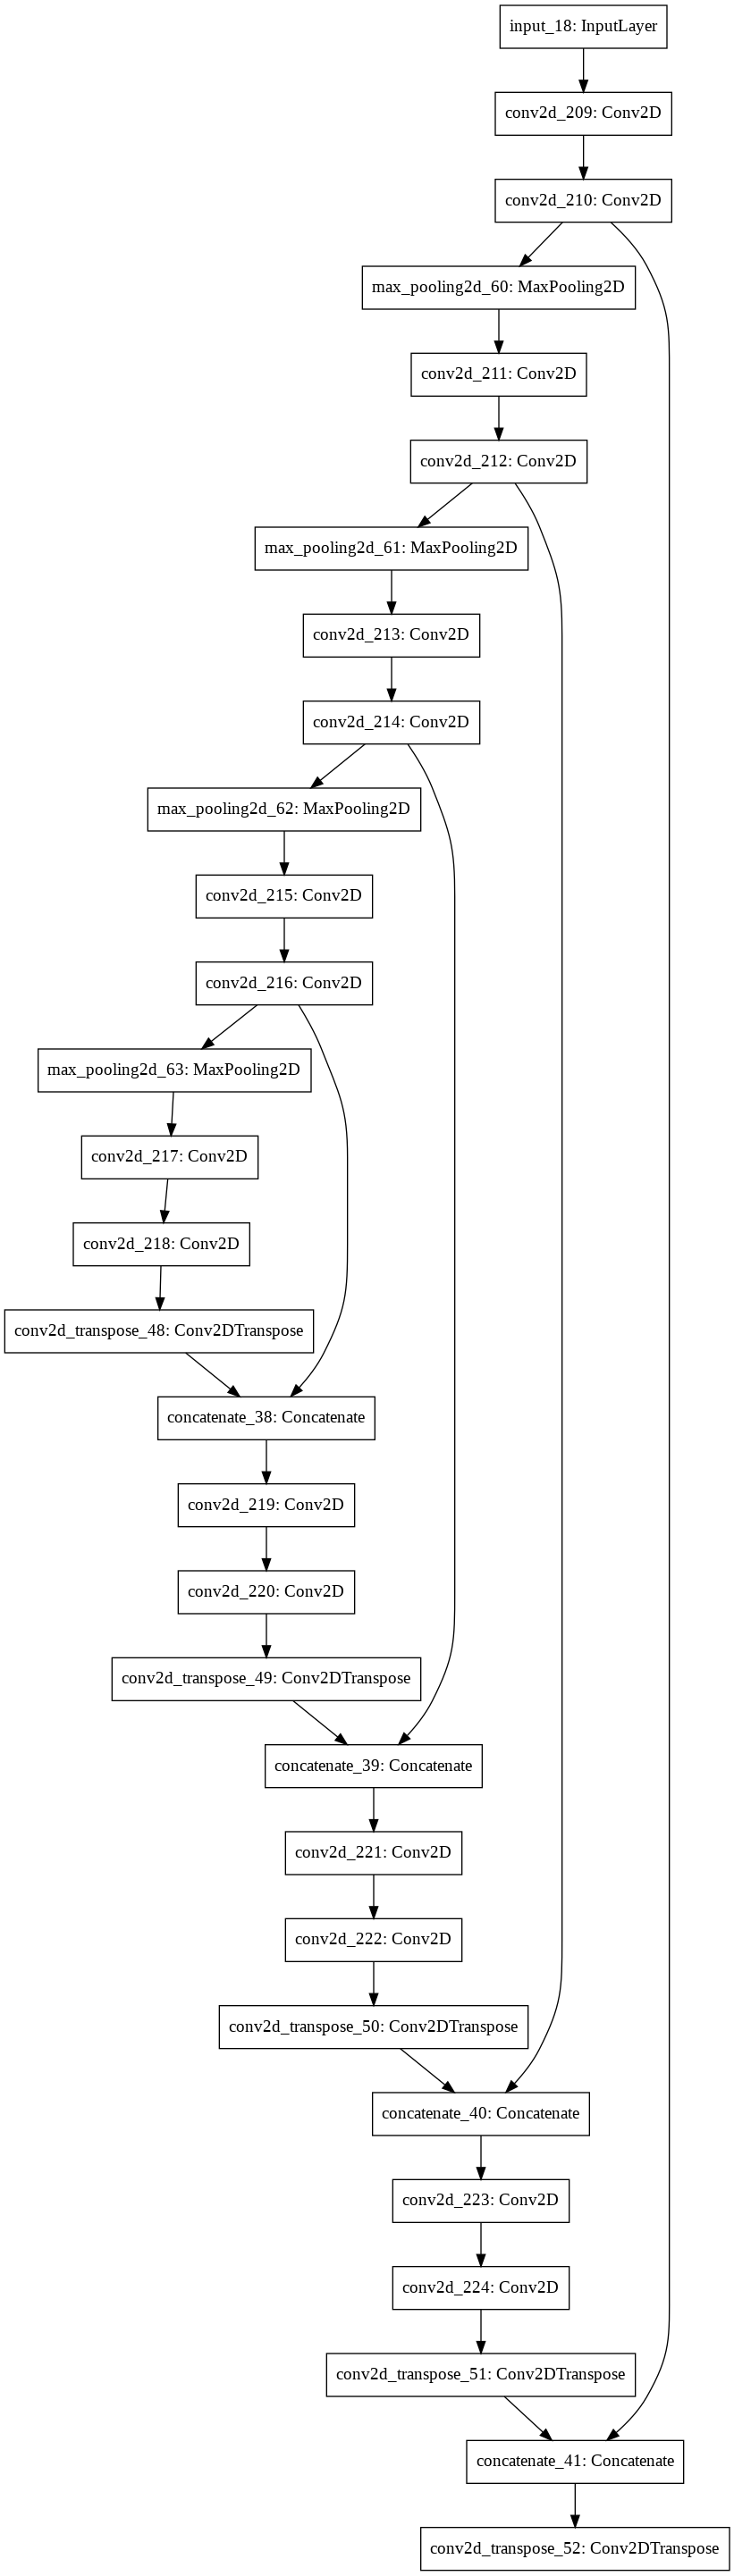

In [105]:
#run the following cell to visualize the created model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### 3. Trainning and testing

#### 3.1 Launch the training
- Use the ```model.fit``` function to launc the training,  
- Measure the overall time with ```%%time``` at the beginning of the notebook cell


In [106]:
%%time
# Fit model
epochs= 40
batch_size= 25

history = model.fit(X_train,Y_train,batch_size=25,epochs=40)

Epoch 1/40
2/2 [==============================] - 3s 843ms/step - loss: 10.6794 - dice_loss: 0.5985
Epoch 2/40
2/2 [==============================] - 2s 885ms/step - loss: 3.7090 - dice_loss: 0.6293
Epoch 3/40
2/2 [==============================] - 2s 895ms/step - loss: 2.1388 - dice_loss: 0.5250
Epoch 4/40
2/2 [==============================] - 2s 885ms/step - loss: 1.7179 - dice_loss: 0.4905
Epoch 5/40
2/2 [==============================] - 2s 913ms/step - loss: 1.5205 - dice_loss: 0.4625
Epoch 6/40
2/2 [==============================] - 2s 940ms/step - loss: 1.4635 - dice_loss: 0.4919
Epoch 7/40
2/2 [==============================] - 2s 901ms/step - loss: 1.4129 - dice_loss: 0.4277
Epoch 8/40
2/2 [==============================] - 2s 869ms/step - loss: 1.2506 - dice_loss: 0.4082
Epoch 9/40
2/2 [==============================] - 2s 876ms/step - loss: 1.1961 - dice_loss: 0.4045
Epoch 10/40
2/2 [==============================] - 2s 918ms/step - loss: 1.1248 - dice_loss: 0.3927
Epoch 11

#### 3.2. Save the model
Save the final model ``model_out.save_weights`` with an hdf5 format. You may also find it useful to create a 
checkpoint ``ModelCheckpoint`` of the current best model up to now during training.


In [107]:
model.save_weights('model1_weights.hdf5')

3.3. Plot the history of the loss and the metrics

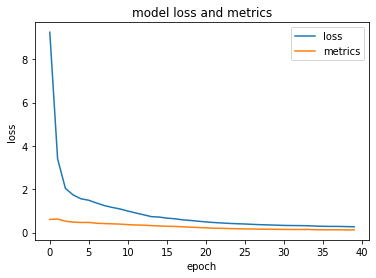

In [108]:
plt.plot(history.history['loss'])
plt.plot(history.history['dice_loss'])
plt.title('model loss and metrics')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'metrics'], loc='upper right')
plt.show()

#### 3.3. Test
Load the test images, make predictions and visualize the predictions 


In [109]:
#if required reload the model
# model.save_weights('model1_weights.hdf5')

In [110]:
#load the test images
%%time
from PIL import Image
X_test = get_images(test_path, output_shape=(img_height,img_width))
print(X_test.shape, X_test.dtype)
predict_imgs = model.predict(X_test)

def MatrixtoImage(data):
    data = data*255
    new = Image.fromarray(data.astype(np.uint8))
    return new

(10, 64, 64, 3) uint8
CPU times: user 797 ms, sys: 369 ms, total: 1.17 s
Wall time: 712 ms


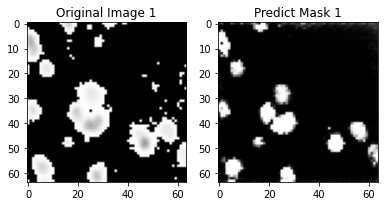

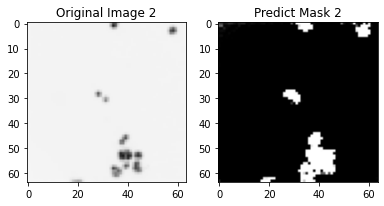

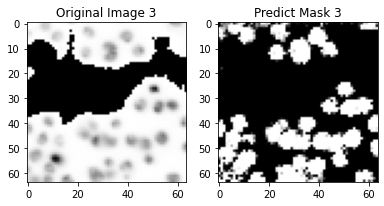

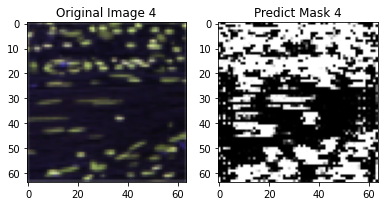

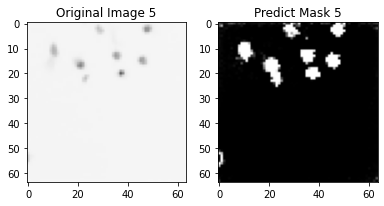

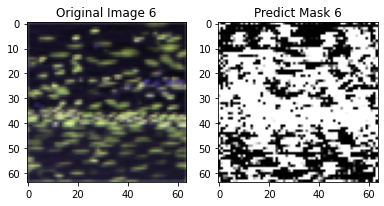

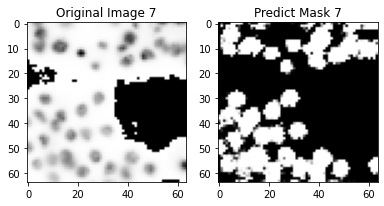

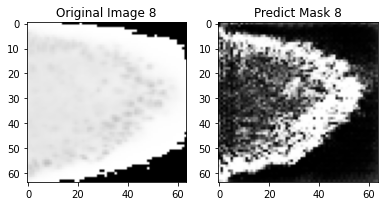

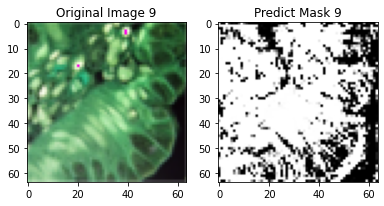

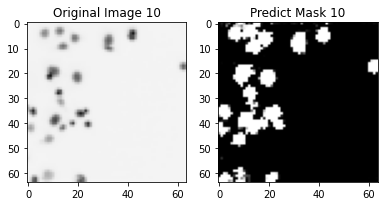

In [114]:
Y_predict = model.predict(X_test)
for i in range(X_test.shape[0]):
  plt.figure(figsize=(20,20))
  im1 = MatrixtoImage(X_test[i])
  plt.subplot(2,6,1),plt.imshow(im1)
  plt.title('Original Image %i' %(i+1))
  im2 = MatrixtoImage(predict_imgs[i][:,:,0])
  plt.subplot(2,6,2),plt.imshow(im2,cmap='gray')
  plt.title('Predict Mask %i' %(i+1))

### 4 Comparison and Improvement

Try making changes to improve the results. Do at least one of the following modifications 
- Change the architecture (use the one from the tf example, or add other types of layers (e.g. dropout) or non-linarities (e.g. leaky relu) and compare the training curves
- add data augmentation (rotation, flip, translation of each image)
- add an explicit validation set and ilustrate the intermediate results and metrics on the validation set
- add data generators (to sample and augment data online)




In this part, we add dropout and LeakyReLU function after every convolution layer. 

---



In [149]:
from keras.layers import LeakyReLU

# In this part, we add dropout and LeakyReLU function after every convolution layer.
 
def Conv2d_BN(x, nb_filter, kernel_size, strides=(1,1), padding='same'):
    x = Conv2D(nb_filter, kernel_size, strides=strides, padding=padding, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x
 
def Conv2dT_BN(x, filters, kernel_size, strides=(2,2), padding='same'):
    x = Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding, kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=3)(x)
    x = LeakyReLU(alpha=0.1)(x)
    return x

def new_unet_model(img_width=256, img_height=256):
    n_channels = [16,32,64,128,256]  #the number of kernels/feature channels per block
    k_size = (3, 3)                  #size of filter kernel
    k_init = 'he_normal'             #kernel initializer
    
    # Use Keras Input layer to create one
    inp = Input(shape=[img_width,img_height,3])

    conv1 = Conv2d_BN(inp, 16, (3, 3))
    conv1 = Conv2d_BN(conv1, 16, (3, 3))
    pool1 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv1)
    
    conv2 = Conv2d_BN(pool1, 32, (3, 3))
    conv2 = Conv2d_BN(conv2, 32, (3, 3))
    pool2 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv2)
    
    conv3 = Conv2d_BN(pool2, 64, (3, 3))
    conv3 = Conv2d_BN(conv3, 64, (3, 3))
    pool3 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv3)
    
    conv4 = Conv2d_BN(pool3, 128, (3, 3))
    conv4 = Conv2d_BN(conv4, 128, (3, 3))
    pool4 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='same')(conv4)
    
    conv5 = Conv2d_BN(pool4, 256, (3, 3))
    conv5 = Dropout(0.5)(conv5)
    conv5 = Conv2d_BN(conv5, 256, (3, 3))
    conv5 = Dropout(0.5)(conv5)
    
    convt1 = Conv2dT_BN(conv5, 128, (3, 3))
    concat1 = concatenate([conv4, convt1], axis=3)
    concat1 = Dropout(0.5)(concat1)
    conv6 = Conv2d_BN(concat1, 128, (3, 3))
    conv6 = Conv2d_BN(conv6, 128, (3, 3))
    
    convt2 = Conv2dT_BN(conv6, 64, (3, 3))
    concat2 = concatenate([conv3, convt2], axis=3)
    concat2 = Dropout(0.5)(concat2)
    conv7 = Conv2d_BN(concat2, 64, (3, 3))
    conv7 = Conv2d_BN(conv7, 64, (3, 3))
    
    convt3 = Conv2dT_BN(conv7, 32, (3, 3))
    concat3 = concatenate([conv2, convt3], axis=3)
    concat3 = Dropout(0.5)(concat3)
    conv8 = Conv2d_BN(concat3, 32, (3, 3))
    conv8 = Conv2d_BN(conv8, 32, (3, 3))
    
    convt4 = Conv2dT_BN(conv8, 16, (3, 3))
    concat4 = concatenate([conv1, convt4], axis=3)
    concat4 = Dropout(0.5)(concat4)
    conv9 = Conv2d_BN(concat4, 16, (3, 3))
    conv9 = Conv2d_BN(conv9, 16, (3, 3))
    conv9 = Dropout(0.5)(conv9)
    outp = Conv2DTranspose(filters=1,kernel_size=k_size,activation='sigmoid',kernel_initializer='glorot_normal',padding='same')(conv9)
    model = Model(inputs=[inp], outputs=[outp])
    return model



In [150]:
new_model = new_unet_model(img_width, img_height)
new_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_297 (Conv2D)             (None, 64, 64, 16)   448         input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_133 (BatchN (None, 64, 64, 16)   64          conv2d_297[0][0]                 
__________________________________________________________________________________________________
leaky_re_lu_128 (LeakyReLU)     (None, 64, 64, 16)   0           batch_normalization_133[0][0]    
___________________________________________________________________________________________

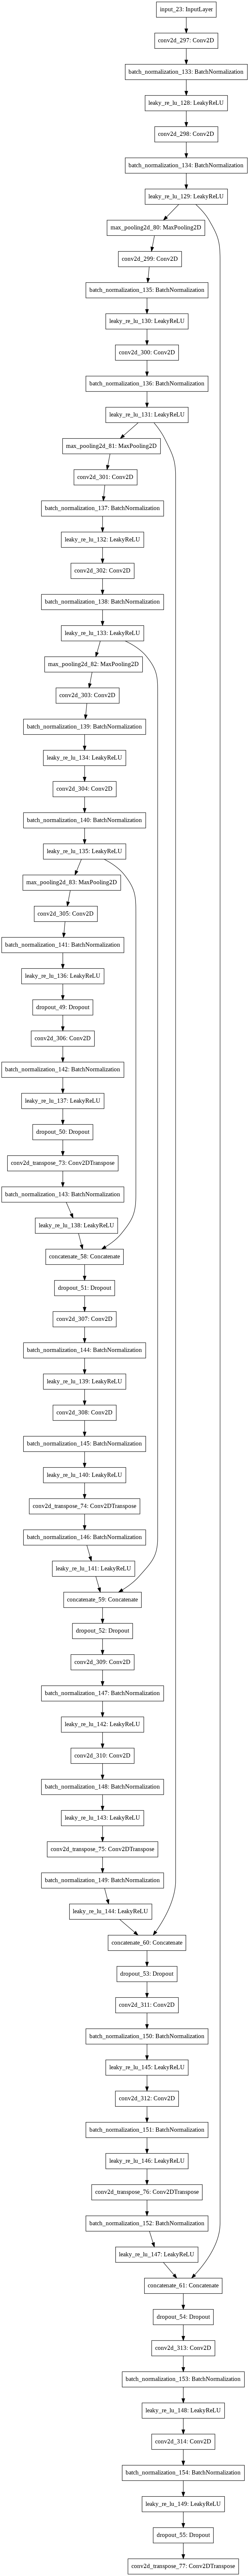

In [156]:
from tensorflow.keras.utils import plot_model
plot_model(new_model, to_file='new_model.png')

In [151]:
new_model.compile(loss=loss,metrics=metrics,optimizer=optimizer)

In [152]:
new_history = new_model.fit(X_train, Y_train, batch_size=batch_size,epochs=epochs)

Epoch 1/40
2/2 [==============================] - 6s 2s/step - loss: 0.7165 - dice_loss: 0.6047
Epoch 2/40
2/2 [==============================] - 3s 2s/step - loss: 0.6441 - dice_loss: 0.5724
Epoch 3/40
2/2 [==============================] - 3s 2s/step - loss: 0.6093 - dice_loss: 0.5426
Epoch 4/40
2/2 [==============================] - 3s 2s/step - loss: 0.5809 - dice_loss: 0.5203
Epoch 5/40
2/2 [==============================] - 3s 2s/step - loss: 0.5447 - dice_loss: 0.4895
Epoch 6/40
2/2 [==============================] - 3s 2s/step - loss: 0.5072 - dice_loss: 0.4444
Epoch 7/40
2/2 [==============================] - 3s 2s/step - loss: 0.4675 - dice_loss: 0.4060
Epoch 8/40
2/2 [==============================] - 3s 2s/step - loss: 0.4232 - dice_loss: 0.3664
Epoch 9/40
2/2 [==============================] - 3s 2s/step - loss: 0.4037 - dice_loss: 0.3482
Epoch 10/40
2/2 [==============================] - 3s 2s/step - loss: 0.3567 - dice_loss: 0.2936
Epoch 11/40
2/2 [======================

In [153]:
new_model.save_weights('new_model1_weights.hdf5')

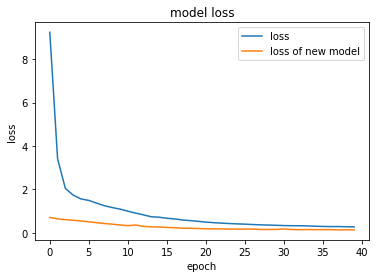

In [154]:
plt.plot(history.history['loss'])
plt.plot(new_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'loss of new model'], loc='upper right')
plt.show()

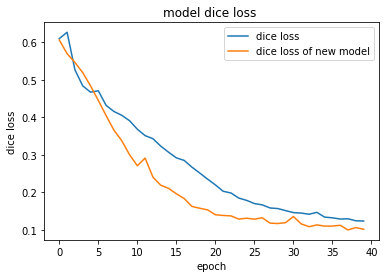

In [155]:
plt.plot(history.history['dice_loss'])
plt.plot(new_history.history['dice_loss'])
plt.title('model dice loss ')
plt.ylabel('dice loss')
plt.xlabel('epoch')
plt.legend(['dice loss', 'dice loss of new model'], loc='upper right')
plt.show()  

# The loss and dice loss of the new model are always smaller than the previous model. 

In [129]:
from PIL import Image
X_test = get_images(test_path, output_shape=(img_height,img_width))
print(X_test.shape, X_test.dtype)
predict_imgs_n = new_model.predict(X_test)

def MatrixtoImage(data):
    data = data*255
    new = Image.fromarray(data.astype(np.uint8))
    return new

(10, 64, 64, 3) uint8


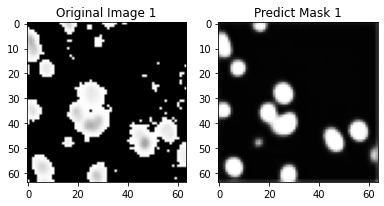

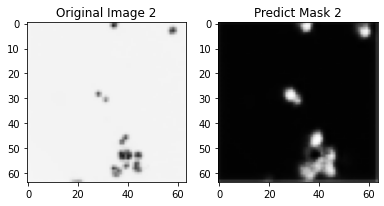

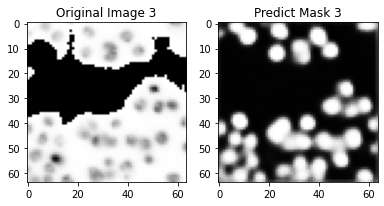

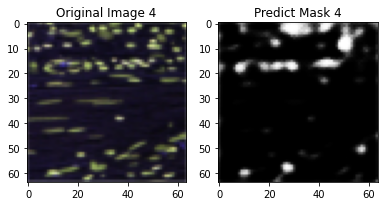

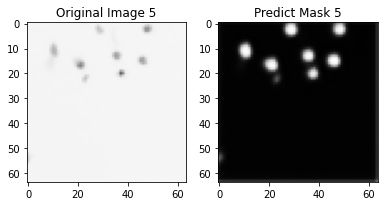

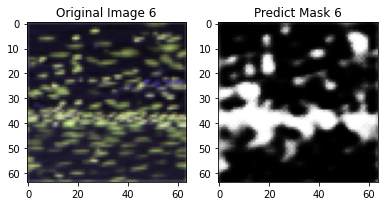

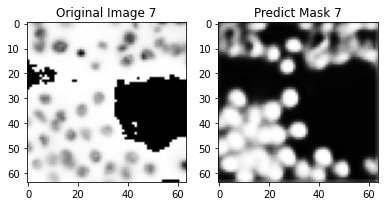

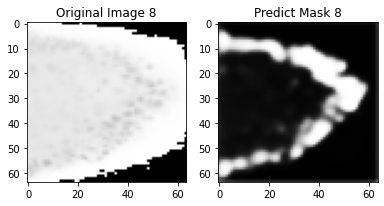

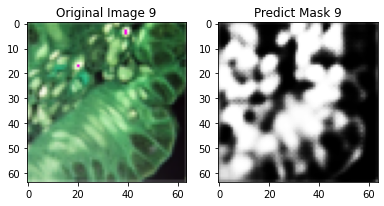

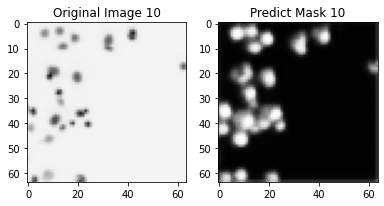

In [130]:
Y_predict = new_model.predict(X_test)
for i in range(X_test.shape[0]):
  plt.figure(figsize=(20,20))
  im1 = MatrixtoImage(X_test[i])
  plt.subplot(2,6,1),plt.imshow(im1)
  plt.title('Original Image %i' %(i+1))
  im2 = MatrixtoImage(predict_imgs_n[i][:,:,0])
  plt.subplot(2,6,2),plt.imshow(im2,cmap='gray')
  plt.title('Predict Mask %i' %(i+1))

**Conclusion:**

We make an improvement of the new model by adding the LeakyReLU layer after every convolutional layer and add dropout to avoid overfitting. We can see from the plot above. The loss and dice loss are always smaller than those of previous model. When we modify the metrics to 'accuracy', the previous model has the accuracy of less than 90% but our new model has the accuracy of 94%. That means the new model is a better one. And we can see the new model predicts more precisely by visualising original images and predicted images. But new model has a large computational cost. It takes 3 seconds per epoch longer than 2 seconds of previous model. Because the model becomes more complex when we add more layers.